## Thinking Glasses On

In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from scipy.interpolate import interp1d

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

### CONCISE

In [3]:
with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())

# Depths will be limited to COW depths
d_df = pd.DataFrame(columns=['T' + str(t) for t in range(30)])
for eddy in the_frontier_eddies:
    row = []
    for t in range(30):
        df = frontier_sample_data[eddy]['T' + str(t)]['COW']['x']
        row.append(df.isna().idxmax() if df.isna().any() else len(df))
    d_df.loc[eddy] = row

# Data is interpolated 
DEPTH_INT = 10
methods = ['VG', 'COW', 'LNAM']
for eddy in the_frontier_eddies:
    for t in range(30):
        for method in methods:
            df = frontier_sample_data[eddy]['T'+str(t)][method]
            # Drop Li 2022 measurement of tilt
            if 'TD' in list(df.columns):
                df = df.drop(columns=['TD'])
            # Centralise at surface center 
            df['x'] = df['x'] - df.iloc[0]['x']
            df['y'] = df['y'] - df.iloc[0]['y']
            # Interpolate to equidistant z-layers
            if df['Depth'].iloc[-1] < z_r[150, 150, d_df.loc[eddy]['T'+str(t)]-1]: # If shorter than COW don't extrapolate
                d = -z_r[150, 150, d_df.loc[eddy]['T'+str(t)]-1]
            else:
                d = -df['Depth'].iloc[-1]
            new_depth = np.arange(0, d, DEPTH_INT)
            interp_x = interp1d(-df['Depth'], df['x'], kind='linear', fill_value="extrapolate")
            interp_y = interp1d(-df['Depth'], df['y'], kind='linear', fill_value="extrapolate")
            df = pd.DataFrame({
                "x": interp_x(new_depth),
                "y": interp_y(new_depth),
                "Depth": -new_depth
            })
            df['TD'] = np.hypot(df['x'], df['y'])
            frontier_sample_data[eddy]['T'+str(t)][method] = df


In [4]:
medium = 'TD'
dic_best_shift = {}
tic = time.time()
for eddy in the_frontier_eddies:
    edic_best_shift = {}
    for method in methods:
        # Find best arangement of eddy profiles
        x1 = frontier_sample_data[eddy]['T0'][method][medium]/1000 
        z1 = frontier_sample_data[eddy]['T0'][method]['Depth']
        df_best_shift = pd.DataFrame({'T0': [0, 0]}, index=['i', 'rmse'])
        xs, zs = [], []
        for t in range(30):
            x2 = frontier_sample_data[eddy]['T'+str(t)][method][medium]/1000
            z2 = frontier_sample_data[eddy]['T'+str(t)][method]['Depth']
            df = pd.DataFrame(columns=['i', 'rmse'])
            for i in np.arange(-30, 31, 1):
                x2_shifted = x2 + i
                rmse = np.sqrt(((x1 - x2_shifted) ** 2).mean())
                df.loc[len(df)] = {'i': i, 'rmse': rmse}
            i_min_rmse = df.loc[df['rmse'] == df['rmse'].min(), 'i'].iloc[0]
            min_rmse = df['rmse'].min()
            df_best_shift['T'+str(t)] = [i_min_rmse, min_rmse]
            xs.extend(x2 + i_min_rmse)
            zs.extend(z2)
        xs = np.array(xs) - np.min(xs)
        df = pd.DataFrame({'x': xs, 'z': zs})        
        edic_best_shift[method] = {'df_best_shift': df_best_shift, 'df': df}
    dic_best_shift[eddy] = edic_best_shift
toc = time.time()
print(f"Elapsed time: {toc - tic:.4f} seconds")

Elapsed time: 21.9502 seconds


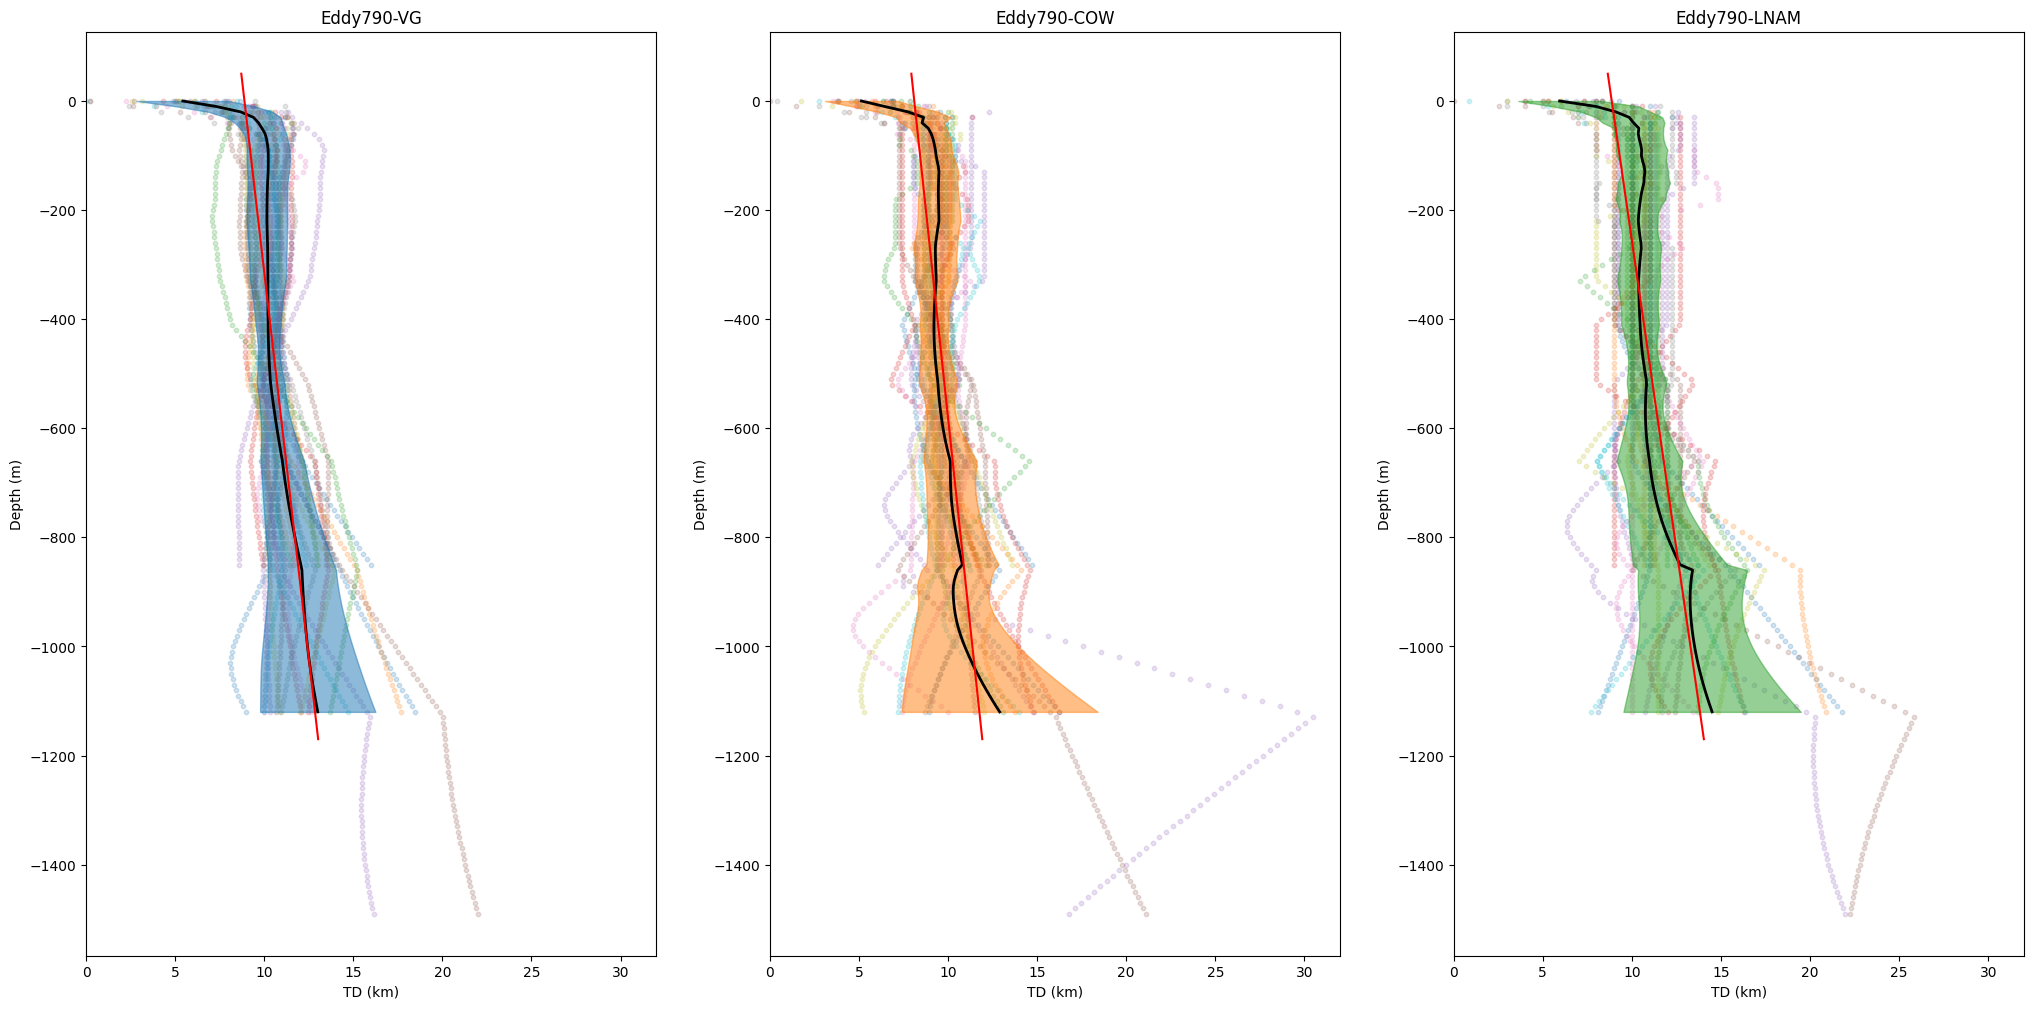

In [7]:
eddy = the_frontier_eddies[0]
medium = 'TD'

fig, axs  = plt.subplots(1, 3, figsize=(25, 12))

colors = plt.get_cmap('tab10')
for j, method in enumerate(methods):

    df_best_shift = dic_best_shift[eddy][method]['df_best_shift']
    xs = dic_best_shift[eddy][method]['df']['x']
    zs = dic_best_shift[eddy][method]['df']['z']
    
    # Plot Data
    xmin = 0
    for t in range(30):
        i = df_best_shift.loc['i']['T'+str(t)]
        xmin = min(np.nanmin(frontier_sample_data[eddy]['T'+str(t)][method][medium])/1000 + i, xmin)
    for t in range(30):
        i = df_best_shift.loc['i']['T'+str(t)]
        axs[j].scatter(frontier_sample_data[eddy]['T'+str(t)][method][medium]/1000 + i - xmin, frontier_sample_data[eddy]['T'+str(t)][method]['Depth'], alpha=.2, s=10)
    
    DATA_THRESH = 5
    # MEAN
    df_mean = pd.DataFrame({'x':xs, 'z': zs})
    df_mean = df_mean.groupby('z').filter(lambda group: len(group) >= DATA_THRESH)
    df_mean = df_mean.groupby('z')['x'].mean().reset_index()
    axs[j].plot(df_mean['x'], df_mean['z'], linewidth=2, color='k')
    # STD
    df_std = pd.DataFrame({'x':xs, 'z': zs})
    df_std = df_std.groupby('z').filter(lambda group: len(group) >= DATA_THRESH)
    df_std = df_std.groupby('z')['x'].std().reset_index()
    axs[j].fill_betweenx(df_mean['z'], 
                      df_mean['x'] - df_std['x'], 
                      df_mean['x'] + df_std['x'], 
                      color=colors(j), alpha=0.5)
    
    # Linear Regression
    x = df_mean['x']
    z = df_mean['z']
    w = 1 / df_std['x']
    
    m, b = np.polyfit(x, z, 1, w=w)
    z_min, z_max = z.min() - 50, z.max() + 50
    x_min = (z_min - b) / m
    x_max = (z_max - b) / m
    x_fit = np.array([x_min, x_max])
    z_fit = m * x_fit + b
    axs[j].plot(x_fit, z_fit, color='red')
    
    axs[j].set_title(eddy + '-' + method)
    axs[j].set_xlabel('TD (km)')
    axs[j].set_ylabel('Depth (m)')

xmax = 0
for ax in axs:
    xmax = max(ax.get_xlim()[1], xmax)
for ax in axs:
    ax.set_xlim(0, xmax)